# Email Spam Detection Project


Use case
You were recently hired in start up company and you were asked to build a system to identify spam emails.

Perform all necessary actions not only limited to,

1. Data Preparation
2. Building word dictionary
3. Feature extraction
4. Training classifiers
5. Testing 
6. Performance evaluation using multiple metrics (Confusion matrix, f1 score, roc, auc)

### LOADING LIBRARIES

In [1]:
# Let's Import all the required libraries

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns



import nltk, re
import string
from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)

### LOADING CSV DATA 

In [2]:
#Let's load the CSV file

email=pd.read_csv('messages.csv')
email

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0
...,...,...,...
2888,love your profile - ysuolvpv,hello thanks for stopping by ! ! we have taken...,1
2889,you have been asked to join kiddin,"the list owner of : "" kiddin "" has invited you...",1
2890,anglicization of composers ' names,"judging from the return post , i must have sou...",0
2891,"re : 6 . 797 , comparative method : n - ary co...",gotcha ! there are two separate fallacies in t...,0


In [3]:
#Let's check if there are null values in our dataset

email.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [4]:
#Let's replace the null values in our dataset

email=email.replace(np.nan,"",regex=True)
email.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [5]:
#Let's check the columns in our dataset

email.columns

Index(['subject', 'message', 'label'], dtype='object')

In [6]:
#Let's re check that we have sucessfully imputed all the null values

email.isnull().sum()

subject    0
message    0
label      0
dtype: int64

In [7]:
#Let's check the datatype of our dataset

email.dtypes

subject    object
message    object
label       int64
dtype: object

In [8]:
#Let;s check the detail info of our dataset

email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2893 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


### DATA VISUALIZATION

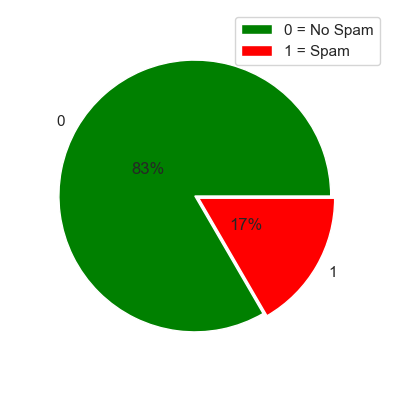

In [9]:
#Let's plot a pie chart to visualize the Spam and non spam mails

label=email['label'].value_counts().index.tolist()
value=email['label'].value_counts().values.tolist()
explode=(0.030,0)
clour=('green','red')
plt.figure(figsize=(8,5),dpi=100)
sns.set_context('talk',font_scale=0.2)
sns.set(style='whitegrid')
plt.pie(x=value,explode=explode,labels=label,colors=clour,autopct='%2.0f%%',pctdistance=0.4, radius=0.9)
plt.legend(["0 = No Spam",'1 = Spam'])
plt.show()

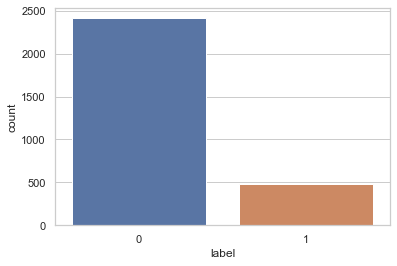

In [10]:
#Let's plot the count of spam mails

sns.countplot(x=email['label']);

In [11]:
# let's print the count numbers from above plot

print('Ham mails as (0) and Spam mails as (1) counts','\n',email.label.value_counts())

Ham mails as (0) and Spam mails as (1) counts 
 0    2412
1     481
Name: label, dtype: int64


In [12]:
# Let's check the percentage of spam mails

print('Ham mail ratio  = ', round(len(email[email['label']==0]) / len(email.label),2)*100,'%')
print('spam mail ratio = ', round(len(email[email['label']==1]) / len(email.label),2)*100,'%')

Ham mail ratio  =  83.0 %
spam mail ratio =  17.0 %


In [13]:
#Let's check the length

email['Subject_length'] = email.subject.str.len()
email['Message_length'] = email.message.str.len()
email.head(5)

,subject,message,label,Subject_length,Message_length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,39,2856
1,,"lang classification grimes , joseph e . and ba...",0,0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,50,1435
3,risk,a colleague and i are researching the differin...,0,4,324
4,request book information,earlier this morning i was on the phone with a...,0,24,1046


### DATA PREPRATION

In [14]:
# Let's convert all the data to lower case for further processing

email['subject'] = email['subject'].str.lower()
email['message'] = email['message'].str.lower()

In [15]:
email

,subject,message,label,Subject_length,Message_length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,39,2856
1,,"lang classification grimes , joseph e . and ba...",0,0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,50,1435
3,risk,a colleague and i are researching the differin...,0,4,324
4,request book information,earlier this morning i was on the phone with a...,0,24,1046
...,...,...,...,...,...
2888,love your profile - ysuolvpv,hello thanks for stopping by ! ! we have taken...,1,28,262
2889,you have been asked to join kiddin,"the list owner of : "" kiddin "" has invited you...",1,34,2163
2890,anglicization of composers ' names,"judging from the return post , i must have sou...",0,34,1039
2891,"re : 6 . 797 , comparative method : n - ary co...",gotcha ! there are two separate fallacies in t...,0,54,2949


In [16]:
# Let's drop all rows containing null values

strings=email.dropna()

### DATA CLEANING

In [17]:
# Let's replace all the unwanted data from the strings of the subject column

# Replace email addresses with 'email'
strings['subject'] = strings['subject'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace URLs with 'webaddress'
strings['subject'] = strings['subject'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
strings['subject'] = strings['subject'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')

# Replace numbers with 'number'
strings['subject'] = strings['subject'].str.replace(r'\d+(\.\d+)?', 'number')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
strings['subject'] = strings['subject'].str.replace(r'£|\$', 'dollers')

In [18]:
# Lets replace all the unwanted data from the strings of the message column

# Replace email addresses with 'email'
strings['message'] = strings['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace URLs with 'webaddress'
strings['message'] = strings['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
strings['message'] = strings['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
    
# Replace numbers with 'number'
strings['message'] = strings['message'].str.replace(r'\d+(\.\d+)?', 'number')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
strings['message'] = strings['message'].str.replace(r'£|\$', 'dollers')

In [19]:
strings.head()

,subject,message,label,Subject_length,Message_length
0,job posting - apple-iss research center,content - length : number apple-iss research c...,0,39,2856
1,,"lang classification grimes , joseph e . and ba...",0,0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,50,1435
3,risk,a colleague and i are researching the differin...,0,4,324
4,request book information,earlier this morning i was on the phone with a...,0,24,1046


In [20]:
# Let's remove the punctuation from subject column

# Remove punctuation
strings['subject'] = strings['subject'].str.replace(r'[^\w\d\s]', ' ')

# Remove leading and trailing whitespace
strings['subject'] = strings['subject'].str.replace(r'^\s+|\s+?$', '')

# Replace whitespace between terms with a single space
strings['subject'] = strings['subject'].str.replace(r'\s+', ' ')

In [21]:
# Let's remove the punctuation from messages column

# Remove punctuation
strings['message'] = strings['message'].str.replace(r'[^\w\d\s]', ' ')

# Remove leading and trailing whitespace
strings['message'] = strings['message'].str.replace(r'^\s+|\s+?$', '')

# Replace whitespace between terms with a single space
strings['message'] = strings['message'].str.replace(r'\s+', ' ')

In [22]:
# Let's check the top 5 entries from our data set post data processing

strings.head()

,subject,message,label,Subject_length,Message_length
0,job posting apple iss research center,content length number apple iss research cente...,0,39,2856
1,,lang classification grimes joseph e and barbar...,0,0,1800
2,query letter frequencies for text identification,i am posting this inquiry for sergei atamas sa...,0,50,1435
3,risk,a colleague and i are researching the differin...,0,4,324
4,request book information,earlier this morning i was on the phone with a...,0,24,1046


### BUILDING WORD DICTIONARY

In [23]:
#Let's create a funtion for Stop words

stop_words = set(stopwords.words('english'))
strings['subject'] = strings['subject'].apply(lambda y: ' '.join(term for term in y.split() if term not in stop_words))
strings['message'] = strings['message'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [24]:
# Let's create a new columns after puncuations, stopwords removal to store the clean data

strings['Subject_clean_length'] = strings.subject.str.len()
strings['Message_clean_length'] = strings.message.str.len()
strings.head()

,subject,message,label,Subject_length,Message_length,Subject_clean_length,Message_clean_length
0,job posting apple iss research center,content length number apple iss research cente...,0,39,2856,37,2192
1,,lang classification grimes joseph e barbara f ...,0,0,1800,0,1475
2,query letter frequencies text identification,posting inquiry sergei atamas satamas umabnet ...,0,50,1435,44,1084
3,risk,colleague researching differing degrees risk p...,0,4,324,4,210
4,request book information,earlier morning phone friend mine living south...,0,24,1046,24,629


In [25]:
# Let's check the total length of the subject and message pre and post data cleaning

print ('Original Length of Subject column:', strings.Subject_length.sum())
print ('Length of Subject column post Cleaning:', strings.Subject_clean_length.sum())
print ('Original Length of messages column:', strings.Message_length.sum())
print ('Length of messages column post Cleaning:', strings.Message_clean_length.sum())

Original Length of Subject column: 91663
Length of Subject column post Cleaning: 79458
Original Length of messages column: 9344743
Length of messages column post Cleaning: 6853758


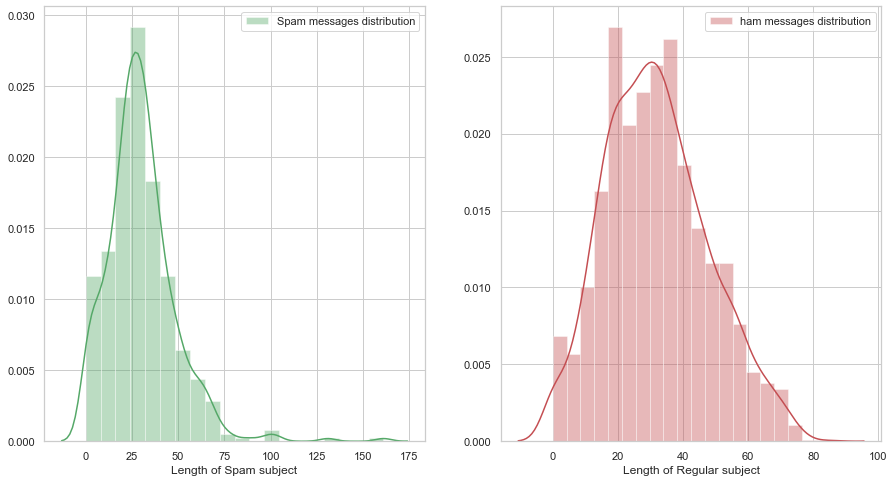

In [26]:
# Let's count the distribution of words before cleaning of Subject column

f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(strings[strings['label']==1]['Subject_length'],bins=20,ax=ax[0],label='Spam messages distribution', color='g')

ax[0].set_xlabel('Length of Spam subject')
ax[0].legend()

sns.distplot(strings[strings['label']==0]['Subject_length'],bins=20,ax=ax[1],label='ham messages distribution', color='r')
ax[1].set_xlabel('Length of Regular subject')
ax[1].legend()

plt.show()

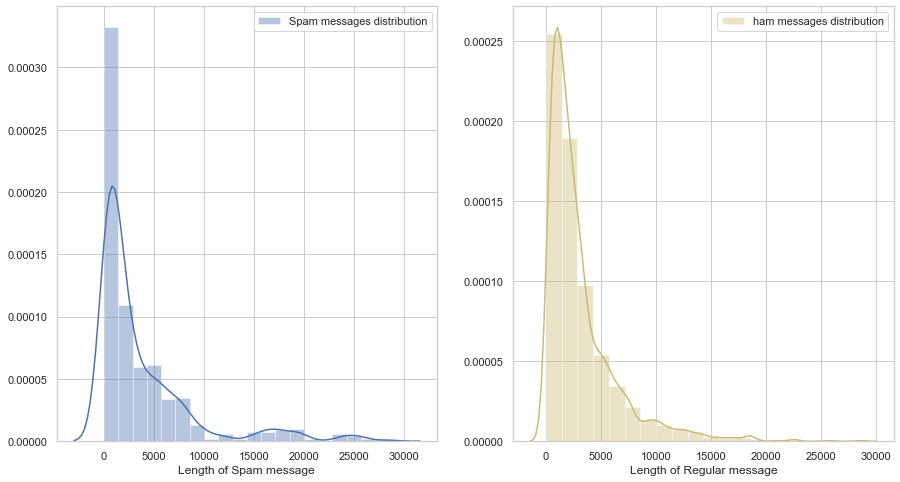

In [27]:
# Let's count the distribution of words before cleaning of message column

f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(strings[strings['label']==1]['Message_length'],bins=20,ax=ax[0],label='Spam messages distribution',color='b')

ax[0].set_xlabel('Length of Spam message')
ax[0].legend()

sns.distplot(strings[strings['label']==0]['Message_length'],bins=20,ax=ax[1],label='ham messages distribution', color='y')
ax[1].set_xlabel('Length of Regular message')
ax[1].legend()

plt.show()

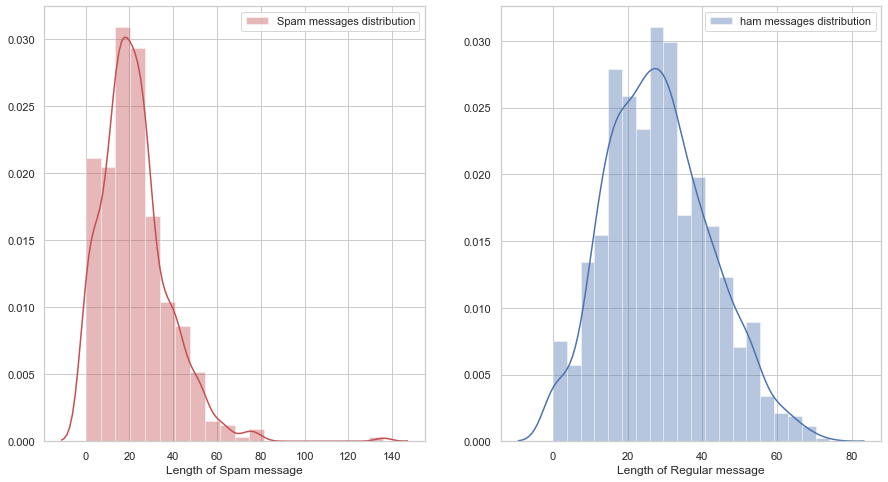

In [28]:
# Let's count the distribution of words after cleaning of subject column

f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(strings[strings['label']==1]['Subject_clean_length'],bins=20,ax=ax[0],label='Spam messages distribution',color='r')
ax[0].set_xlabel('Length of Spam message')
ax[0].legend()

sns.distplot(strings[strings['label']==0]['Subject_clean_length'],bins=20,ax=ax[1],label='ham messages distribution')
ax[1].set_xlabel('Length of Regular message')
ax[1].legend()

plt.show()

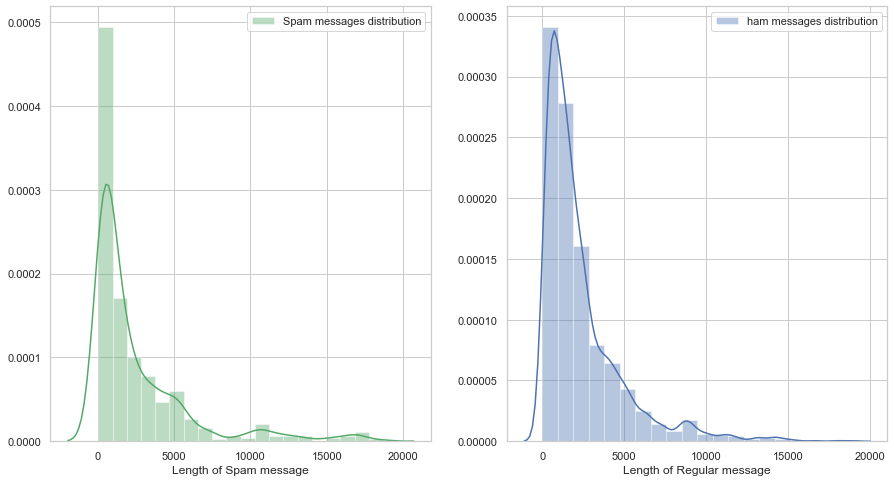

In [29]:
# Let's count the distribution of words after cleaning of message column

f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(strings[strings['label']==1]['Message_clean_length'],bins=20,ax=ax[0],label='Spam messages distribution',color='g')
ax[0].set_xlabel('Length of Spam message')
ax[0].legend()

sns.distplot(strings[strings['label']==0]['Message_clean_length'],bins=20,ax=ax[1],label='ham messages distribution', color='b')
ax[1].set_xlabel('Length of Regular message')
ax[1].legend()

plt.show()

### FEATURE EXTRACTION

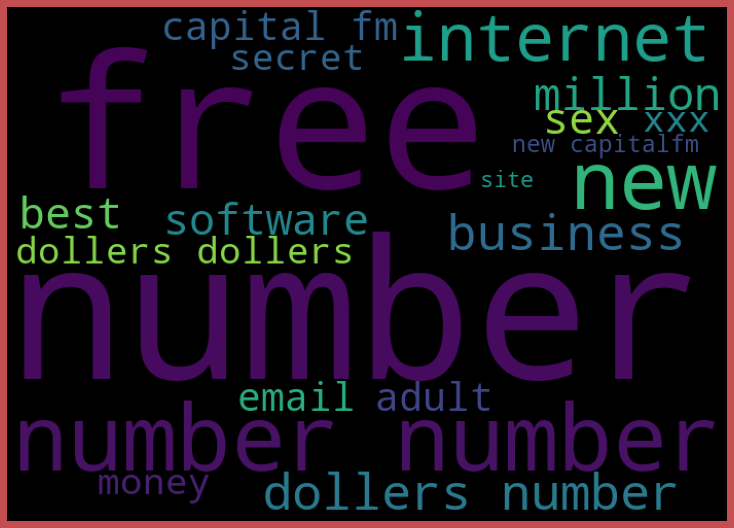

In [30]:
# Let's plot the loud words in spam for subject column

spams = strings['subject'][strings['label']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='black',max_words=20).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

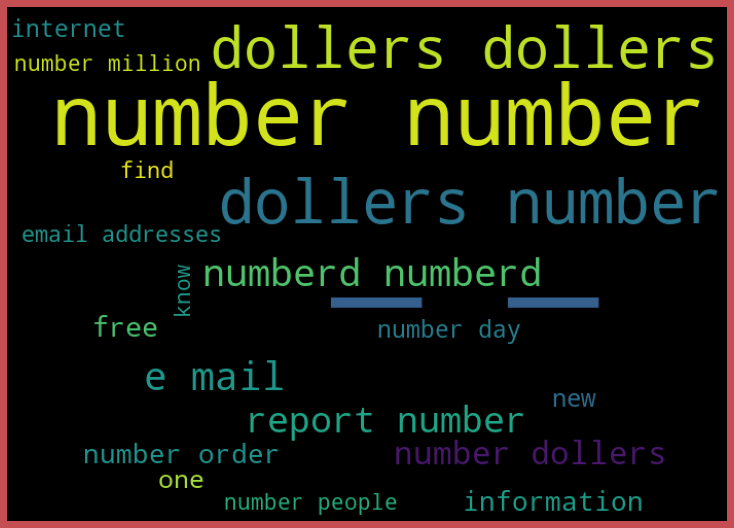

In [31]:
# Let's plot the loud words in spam for message column

spams = strings['message'][strings['label']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='black',max_words=20).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

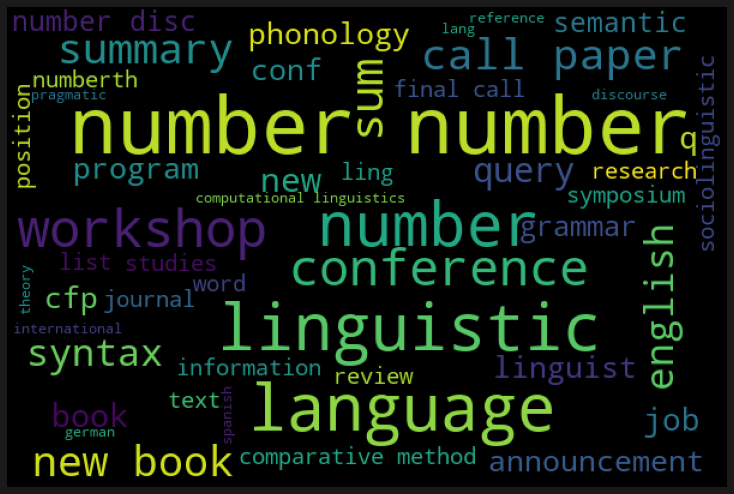

In [32]:
# Let's plo the loud words in regular emails for subject column 

regular = strings['subject'][strings['label']==0]
regular_cloud = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(regular))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(regular_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

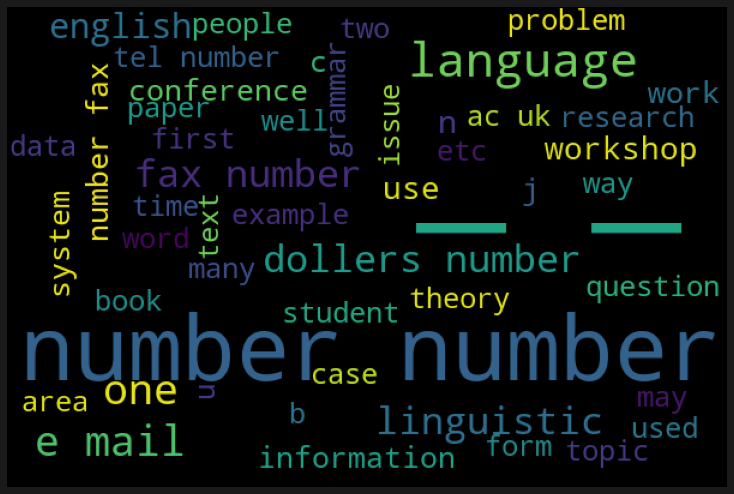

In [33]:
# Let's plot the loud words in regular emails for message column 

regular = strings['message'][strings['label']==0]
regular_cloud = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(regular))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(regular_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### TRAINING CLASSIFIERS

In [34]:
# Let's convert text into vectors using TF-IDF

#Let's split test train data
tf_vec = TfidfVectorizer()

strings["complete_string"] = strings["subject"] + strings["message"]

x = tf_vec.fit_transform(strings["complete_string"])
y = strings['label']


# Let's train our data
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42)

### TESTING

#### Let's use GridSearchCV to find the best parameters

In [35]:
# Let's find the best parameters for logistic Regression

lg=LogisticRegression()
parameters={'penalty':['l1','l2']}
gd=GridSearchCV(lg,parameters)
gd.fit(x_train,y_train)
gd.best_params_

{'penalty': 'l2'}

In [36]:
# Let's find the best parameters for DecisionTree

dt=DecisionTreeClassifier()
parameters={'criterion':('gini','entropy')}
gd=GridSearchCV(dt,parameters)
gd.fit(x_train,y_train)
gd.best_params_

{'criterion': 'entropy'}

In [37]:
# Let's find the best parameters for KNeighborsClassifier

kn=KNeighborsClassifier()
parameters={'n_neighbors':(1,30)}
gd=GridSearchCV(kn,parameters)
gd.fit(x_train,y_train)
gd.best_params_

{'n_neighbors': 1}

In [38]:
# Our model with best parameters

KNN=KNeighborsClassifier(n_neighbors= 1)
LR=LogisticRegression(penalty='l2')
DT=DecisionTreeClassifier(criterion='entropy')
RF= RandomForestClassifier(n_estimators=100,random_state=42)
AD= AdaBoostClassifier()
MNB = MultinomialNB()

In [39]:
# Let's create a for loop function for our model

models=[]
models.append(('LogisticRegression',LR))
models.append(('DecisionTreeClassifier',DT))
models.append(('KneighborsClassifier',KNN))
models.append(('RandomForestClassifier',RF))
models.append(('AdaBoostClassifier',AD))
models.append(('MultinomialNB',MNB))

LogisticRegression Model :-

LogisticRegression()



Accuracy score = 0.9475138121546961


cross validation score = 0.9533301515332298


roc_auc_score =  0.866051773965443


classification_report
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       585
           1       0.99      0.73      0.84       139

    accuracy                           0.95       724
   macro avg       0.97      0.87      0.91       724
weighted avg       0.95      0.95      0.94       724



[[584   1]
 [ 37 102]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)



DecisionTreeClassifier Model :-

DecisionTreeClassifier(criterion='entropy')



Accuracy score = 0.9668508287292817


cross validation score = 0.9661245674740483


roc_auc_score =  0.9548053864600627


classification_report
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       585
           1       0.90      0.94      0.92       139

    accuracy  

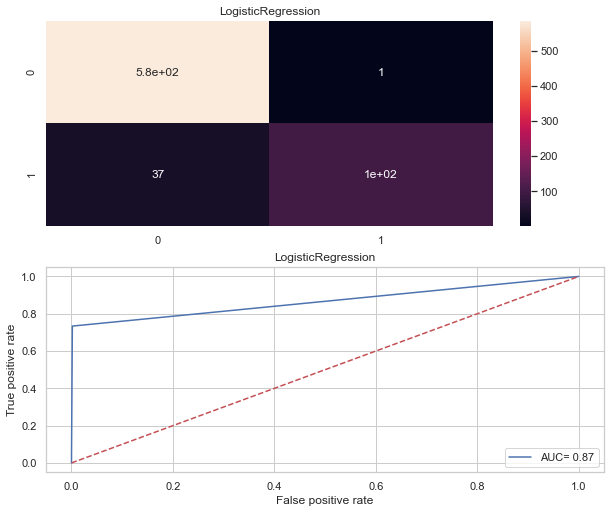

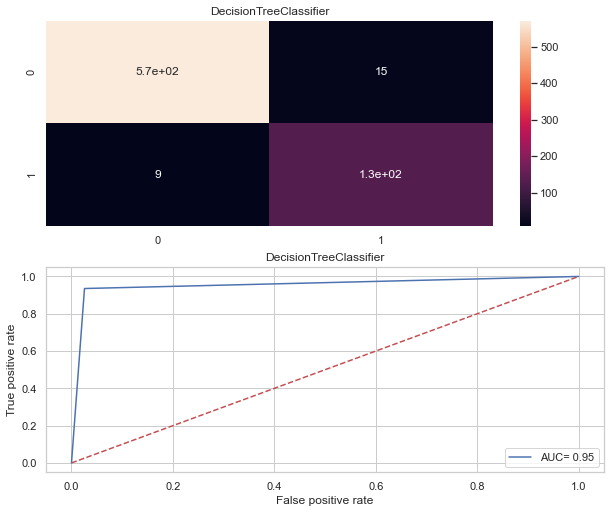

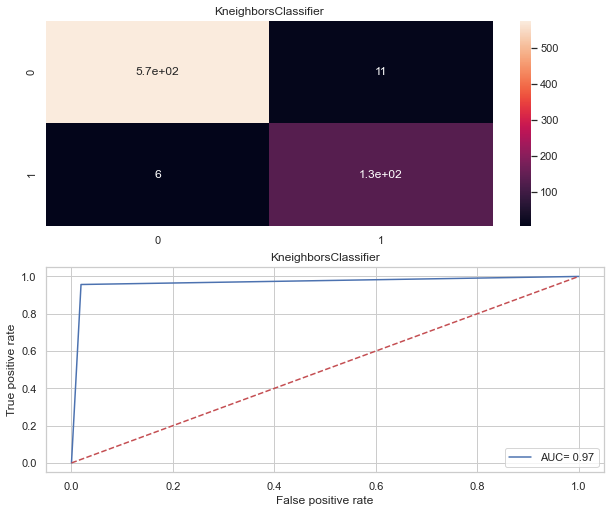

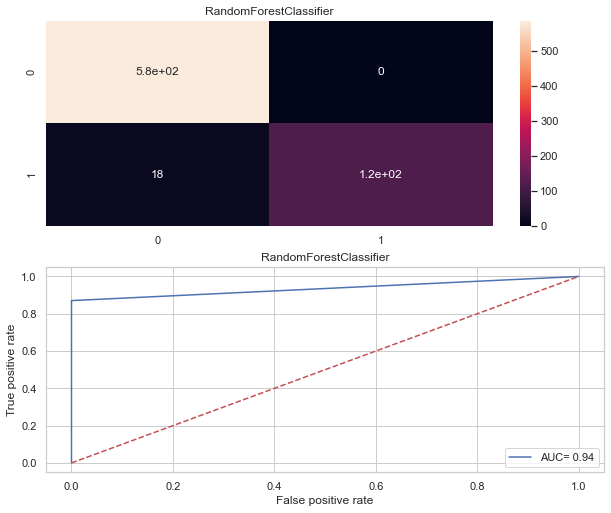

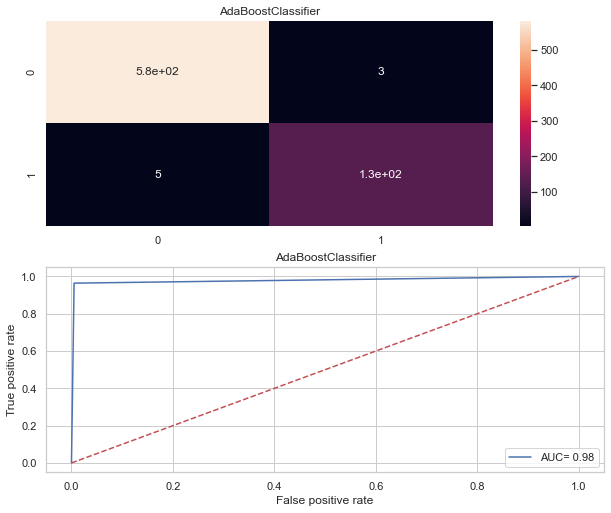

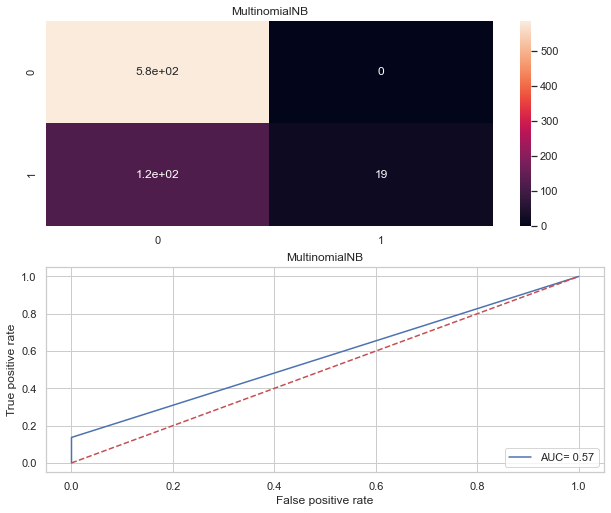

In [40]:
model_list=[]
score=[]
cvs=[]
rocscore=[]

for name, model in models:
    print(name,'Model :-',end='\n\n')
   
    model_list.append(name)
    model.fit(x_train,y_train)
    print(model,end='\n\n')
    pre=model.predict(x_test)
    print('\n')
    AS=accuracy_score(y_test,pre)
    print('Accuracy score =',AS)
    score.append(AS*100)
    print('\n')
    sc=cross_val_score(model,x,y, cv=10, scoring='accuracy').mean()
    print('cross validation score =',sc)
    cvs.append(sc*100)
    print('\n')
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test,pre)
    roc_auc=auc(false_positive_rate,true_positive_rate)
    print('roc_auc_score = ', roc_auc)
    rocscore.append(roc_auc*100)
    print('\n')
    print('classification_report\n',classification_report(y_test,pre))
    print('\n')
    cm=confusion_matrix(y_test,pre)
    print(cm)
    print('\n')
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    print(sns.heatmap(cm,annot=True))
    plt.subplot(912)
    plt.title(name)
    plt.plot(false_positive_rate,true_positive_rate, label='AUC= %0.2f'%roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    print('\n\n')

In [41]:
# Let's create a Dataframe for our above models

result=pd.DataFrame({'Model': model_list, 'Accuracy_score': score, 'Cross_val_score':cvs,'Roc_auc_score': rocscore})
result

,Model,Accuracy_score,Cross_val_score,Roc_auc_score
0,LogisticRegression,94.751381,95.333015,86.605177
1,DecisionTreeClassifier,96.685083,96.612457,95.480539
2,KneighborsClassifier,97.651934,96.854313,96.901556
3,RandomForestClassifier,97.513812,97.338742,93.525180
4,AdaBoostClassifier,98.895028,98.202005,97.945029
5,MultinomialNB,83.425414,86.069443,56.834532


### PERFORMANCE EVALUATION USING MULTIPLE METRICS

After comparing all the models I have choosen the AdaBoostClassifier because it has the highest scores. 

**Accuracy score = 98.89%**

**cross validation score = 98.20%**

**roc_auc_score =  97.94%**

**classification_report**
       
                 precision    recall  f1-score   support

           0       0.99      0.99      0.99       585
           1       0.98      0.96      0.97       139

**accuracy**

                                        0.99       724

**macro avg**

                    0.98      0.98      0.98       724

**weighted avg**

 
                    0.99      0.99      0.99       724


**Confusion matrix:**

    [582   3]
    [  5 134]

**It only classified 8 out of 716 entries incorrectly.**

We ran the results for the "Subject" and "Message" columns separately but we got the same results as when they are combined.
So, we have included the analysis of both columns combined.

### SAVING THE MODEL

In [42]:
#Let's save the model as a pickle file

import joblib
joblib.dump(AD,'Email_Spam_Detection.pkl')

['Email_Spam_Detection.pkl']

In [43]:
#Let's load and use model to make a prediction

model=joblib.load('Email_Spam_Detection.pkl')
model.predict(x_test)

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,